In [1]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from time import gmtime, strftime
import datetime
from numpy import nan
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
%matplotlib inline

In [2]:
data_full = pd.read_csv("MoveInSyncData-final.csv")
print(data_full.head())
np.shape(data_full)
#data = data_full.head(500)
data = data_full
print(data.columns.values)
data_rows = data.shape[0]
data_col = data.shape[1]
data_transformed = pd.DataFrame()
data.reset_index(drop = True, inplace = True)
data.head()
print(data.shape)

  employee_id  trip_id trip_type  gender  cab_type trip_state_text  \
0    ATT-0001   461353    LOGOUT    MALE  4 Seater       COMPLETED   
1    ATT-0002   461528     LOGIN    MALE  4 Seater       COMPLETED   
2    ATT-0003   461849    LOGOUT    MALE  4 Seater       COMPLETED   
3    ATT-0004   461431    LOGOUT    MALE  4 Seater       COMPLETED   
4    ATT-0005   461915     LOGIN  FEMALE  4 Seater       COMPLETED   

  planned_pickup_time  pickup_geoX  pickup_geoY  drop_geoX  ...  \
0      5/16/2019 6:45    12.923583    77.671061  12.988366  ...   
1      5/16/2019 6:26    12.955146    77.738991  12.934748  ...   
2     5/16/2019 15:45    12.924626    77.671098  12.968512  ...   
3      5/16/2019 1:45    12.924514    77.671051  13.043238  ...   
4      5/16/2019 6:09    12.921150    77.646636  12.923322  ...   

   total_distance  costoftrip  perpersoncost hour_shift  minute_shift  hour  \
0       30.629322  155.066034      77.047147          6            30   6.0   
1        7.177641 

In [3]:
## Defining set of functions required for feature transformation 

# Generic functions
def one_hot(x):
    num_rows = x.shape[0]
    unique_list = []
    
    for i in range(0,num_rows):
        if(x[i] not in unique_list):
            unique_list.append(x[i])
    print("column key is:", unique_list)
    unique_list_length = np.size(unique_list)
    one_hot_vector = np.zeros((num_rows,unique_list_length))
    
    for i in range(0,num_rows):
        for j in range(0,unique_list_length):
            if x[i]==unique_list[j]:
                one_hot_vector[i][j] = 1
    
    return(one_hot_vector)

def freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    return d


def ordinal_many_hot(z,ordered_list):
    num_rows = np.size(z)
    num_col = np.size(ordered_list)-1
    ordinal_vector = np.zeros((num_rows,num_col))
    
    for i in range(0,num_rows):
        j=ordered_list.index(z[i])
        if j > 0:
            for k in range(0, j):
                ordinal_vector[i,k]=1
    
    return(ordinal_vector)   



#feature transformation 1 - One hot vector for Hour of the request.
def hour(x):
    y = x.find(':')
    z = int(x[0:y])
    return(z) 

#feature transformation 2 - One hot vector for quardant of Hour of the request. 
def minute(z):
    if z <=15:
        return(1)  #1st quardant
    elif 15<z<=30:
        return(2)  #2nd quardant
    elif 30<z<=45:
        return(3)  #3rd quardant
    else:
        return(4)  #4th quardant
    
#feature transformation 4 - One hot vector for day of the week
#0 = sunday, 1= monday, 2 = tuesday and so on
def day_of_week(x):
    y_1 = x.find('/')
    #print(y_1)
    y_2 = x.find('/', y_1+1)
    #print(y_2)
    
    date = x[y_1+1:y_2]
    #print(date)
    if(len(date) == 1):
        date = "0"+date
        
    month = x[0:y_1]
    #print(month)
    if(len(month) == 1):
        month = "0"+month
    
    year = "20"+x[y_2+1:len(x)]
    #print(year)
    
    date = month+","+date+","+year
    print(date)
        
    day_of_week = datetime.datetime.strptime(date, '%m,%d,%Y').strftime('%w')
    
    return(int(day_of_week))


# Feature # 10: calculates customer location density at 2 decimal points
def cx_loc_density(cx_lat_long_X,cx_lat_long_Y, z):
#     print("x =", x)
    num_rows = cx_lat_long_X.shape[0]
    lat_long = np.zeros((num_rows,2))
    lat_long_concat = [None]*num_rows
    x_final_cat = [None]*num_rows
    
    
    for i in range(0,num_rows):
        lat = cx_lat_long_X[i]
        long = cx_lat_long_Y[i]
#         print(lat)
#         print(long)
        lat_shortened = str(round(lat,z)) #12.42 (2 digits post decimal)
        long_shortened = str(round(lat,z))
        lat_long_concat[i] = lat_shortened+"-"+long_shortened
    
    #print(lat_long_concat)
            
    unique_list = []
    
    for i in range(0,num_rows):
        if(lat_long_concat[i] not in unique_list):
            unique_list.append(lat_long_concat[i])
            
#     print("unique_list =", unique_list)
    L = len(unique_list)
#     print(np.size(unique_list))
    
    # counting occurance of unique items 
    
    unique_list_freq = []
    
    for i in range(0,L):
        y = lat_long_concat.count(unique_list[i])
        a = [unique_list[i], y]
        unique_list_freq.append(a)
#     print("unique_list_freq =", unique_list_freq)
    
    unique_list_freq.sort(key=lambda x: x[1])
#     print(unique_list_freq)
        
    # Assigning cateogries = {1,2,3,4,5} to the unique list. 5 being with highest density. 
    # Ideally we woudl want to do it for geohash-hour level densities, but due to data sparsity that matrix may not useful. 
    # further cuts for day of week etc can be make to get this density function. but we are not getting into those comlexities as of now.
    # if current transformation do not work, we can explore some of these enhancements. 
    
    unique_list_freq_sum = np.zeros(L)
    for i in range(0,L):
        b = 0
        for j in range(0,i):
            b = b+unique_list_freq[j][1]
        unique_list_freq_sum[i] = b
        
    category = [None]*L
    
#     print("L=", L)
    for i in range(0,L):
        if unique_list_freq_sum[i] <= num_rows*0.2:
            category[i] = '1'
        elif ((num_rows*0.2) < unique_list_freq_sum[i] <= (num_rows*0.4)): 
            category[i] = '2'
        elif ((num_rows*0.4) < unique_list_freq_sum[i] <= (num_rows*0.6)): 
            category[i] = '3'
        elif ((num_rows*0.6) < unique_list_freq_sum[i] <= (num_rows*0.8)): 
            category[i] = '4'
        else: 
            category[i] = '5'
    
    
    ### Assignging categories for input data points
    
    x_final_cat = ['5']*num_rows
    for i in range(0,num_rows):
        for j in range(0,L-1):
            if lat_long_concat[i] == unique_list_freq[j][0]:
                x_final_cat[i] = category[j]         
        
#     print(unique_list_freq)
#     print(category)
#     print(x_final_cat)
    
    return(x_final_cat)

#feature transformation 11 - traffic points on the way

# x is array containing lat longs. 
# z is digits after decimal. 

def geo_hash_trim(x,z):
    num_rows = x.shape[0]
    lat_long = np.zeros((num_rows,1))
    
    for i in range(0,num_rows):
        y = x[i]
        lat_long[i] = round(y,z)
    return(lat_long)

#returns distance in meters. 
#assumes all inputs in 2 decimal digit significance, hence multiplier of 110. 
#areal distance
def line_point_distance(x1,y1,x2,y2,xp,yp):
    p1=np.array([x1,y1])
    p2=np.array([x2,y2])
    p3=np.array([xp,yp])
    d=abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))*110
    #print ("distance from line=", d)
    return(d) 

#x==4 column array (x1,y1,x2,y2), 
#y==2 column array with points xp,yp in each row, 
#threshhold in meters. 
def num_points_nearby(from_to,point,threshold):
    #print(point)
    num_row = np.shape(from_to)[0]
    #print(num_row)
    num_points = np.shape(point)[0]
    #print(num_points)
    points_on_the_way = np.zeros(num_row)
    
    for i in range(0,num_row):
#         print(from_to[i,0])
#         print(from_to[i,1])
#         print(from_to[i,2])
#         print(from_to[i,3])
#         print(point[0])
#         print(point[1])
        distance = line_point_distance(from_to[i,0],from_to[i,1],from_to[i,2],from_to[i,3],point[0],point[1])
        if(distance <= threshold):
            #print(j, "lies near connecting line")
            points_on_the_way[i] = 1
                
    return(points_on_the_way)


In [4]:
#feature transformation 1 - One hot vector for Hour of the request.

X_hour = np.zeros((data_rows,24))
for i in range(0,(data_rows)):
    y = int(data["hour"][i])
    X_hour[i,y-1] = 1    ##X[i,j] indices i nd j starts from 0. 
X_hour.shape

#feature transformation 2 - One hot vector for quardant of Hour of the request. 

X_min = np.zeros((data_rows,4))
for i in range(0,(data_rows)):
    y = minute(data["minute"][i])
    X_min[i,y-1] = 1
X_min.shape

#feature transformation 3 - One hot vector for month. 
X_month = np.zeros((data_rows,12))
for i in range(0,(data_rows)):
    y = data["month"][i]
    X_month[i,y-1] = 1
X_month.shape

#feature transformation 4 - One hot vector for day of the week

X_dow = np.zeros((data_rows,8))
for i in range(0,(data_rows)):
    y = data["day"][i]
    X_dow[i,y] = 1  
print(X_dow.shape)
sum(sum(X_dow))

#feature transformation 5 - One hot vector for office location
 
X_office = one_hot(data["Company"])
print(X_office.shape) 

#feature transformation 6 - trip_type
    
X_trip_type = one_hot(data["trip_type"])
X_trip_type.shape

#feature transformation 7 - gender

X_gender = one_hot(data["gender"])
X_gender.shape

#feature transformation 8 - distance

X_distance = data["distance"].as_matrix().reshape(len(data["distance"]),1)
#print(X_distance.shape)

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_distance_poly = poly.fit_transform(X_distance)
np.shape(X_distance_poly)


#feature transformation 9 - cab_type

X_cab_type = one_hot(data["cab_type"])
X_cab_type.shape

#feature transformation 10 - user_location_density one hot

data.loc[data["trip_type"] == "LOGOUT", "cx_lat_long_X"] = data["drop_geoX"]
data.loc[data["trip_type"] == "LOGOUT", "cx_lat_long_Y"] = data["drop_geoY"]

data.loc[data["trip_type"] == "LOGOUT", "office_lat_long_X"] = data["pickup_geoX"]
data.loc[data["trip_type"] == "LOGOUT", "office_lat_long_Y"] = data["pickup_geoY"]

data.loc[data["trip_type"] == "LOGIN", "cx_lat_long_X"] = data["pickup_geoX"]
data.loc[data["trip_type"] == "LOGIN", "cx_lat_long_Y"] = data["pickup_geoY"]

data.loc[data["trip_type"] == "LOGIN", "office_lat_long_X"] = data["drop_geoX"]
data.loc[data["trip_type"] == "LOGIN", "office_lat_long_Y"] = data["drop_geoY"]


      # 2 significant digit is showing large number of uniques points (23), hence 1 significant digit is used. might changes once we have more data. 
z = cx_loc_density(data["cx_lat_long_X"],data["cx_lat_long_Y"],2)

freq(z)

ordered_list = ['1', '2', '3', '4', '5']
X_cx_density = ordinal_many_hot(z,ordered_list)
# print(X_cx_density)
# print(X_cx_density.shape)
# (sum(X_cx_density))

#feature transformation 11 - traffic points on the way

traffic_points = [[12.9, 77.6],[12.95, 77.70],[13.01, 77.58],[13.00, 77.67],[12.92, 77.66]]
#silk board: 12.91, 77.62
#marathalli bridge: 12.95, 77.70
#mekhari circle: 13.01, 77.58
#KR puram junction: 13.00, 77.67
# Sarjapur junciton: 12.92, 77.66

cx_trimmed_lat_long_X = geo_hash_trim(data["cx_lat_long_X"],3)
cx_trimmed_lat_long_Y = geo_hash_trim(data["cx_lat_long_Y"],3)
office_trimmed_lat_long_X = geo_hash_trim(data["office_lat_long_X"],3)
office_trimmed_lat_long_Y = geo_hash_trim(data["office_lat_long_Y"],3)

from_to_lat_long = np.concatenate((cx_trimmed_lat_long_X, cx_trimmed_lat_long_Y, office_trimmed_lat_long_X, office_trimmed_lat_long_Y), axis=1)
X_traffic_points = pd.Series()
#print(type(X_traffic_points))
for i in range(0, len(traffic_points)):
    A = num_points_nearby(from_to_lat_long,traffic_points[i], 3)
    A = pd.Series(A)
    X_traffic_points = pd.concat([X_traffic_points, A], axis=1)
#print(type(X_traffic_points))
    
X_traffic_points = X_traffic_points.iloc[:,1:]
print(X_traffic_points.shape)
print((X_traffic_points))
#X_traffic_points

#feature transformation 12 - speed categorization of office_cx geo hash

### speed data does not look accurate


#feature transformation 13 - escort prediction (using SVM classifier)
#seperate file
X_escort = one_hot(data["required_escort_y"])
X_escort = X_escort[:,:-1]

print(np.shape(X_escort))
print(type(X_escort))

(488472, 8)
column key is: [1, 3, 4, 2, 7, 5, 6, 9, 8, 10]
(488472, 10)
column key is: ['LOGOUT', 'LOGIN']
column key is: ['MALE', 'FEMALE']


/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


column key is: ['4 Seater', '6 Seater', 'Xylo', '4Seater', '4 SEATER', 'Sumo', 'Indica', 'TT', 'SEDAN', 'INOVO', 'Sedan', nan]


/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide


(488472, 5)
          1    0    0    0    0
0       0.0  0.0  0.0  0.0  1.0
1       1.0  1.0  0.0  0.0  1.0
2       0.0  0.0  0.0  0.0  1.0
3       0.0  1.0  0.0  1.0  1.0
4       1.0  1.0  0.0  0.0  1.0
5       1.0  1.0  0.0  0.0  1.0
6       1.0  1.0  0.0  0.0  1.0
7       0.0  1.0  0.0  0.0  0.0
8       1.0  1.0  0.0  0.0  1.0
9       0.0  1.0  0.0  1.0  1.0
10      1.0  1.0  0.0  0.0  1.0
11      0.0  0.0  1.0  1.0  0.0
12      1.0  1.0  0.0  0.0  1.0
13      0.0  0.0  0.0  0.0  1.0
14      0.0  0.0  0.0  1.0  1.0
15      0.0  0.0  0.0  0.0  1.0
16      1.0  1.0  0.0  0.0  1.0
17      1.0  1.0  0.0  0.0  1.0
18      0.0  0.0  0.0  0.0  1.0
19      0.0  0.0  0.0  0.0  1.0
20      0.0  0.0  0.0  0.0  1.0
21      0.0  0.0  1.0  1.0  0.0
22      0.0  1.0  0.0  1.0  1.0
23      1.0  1.0  0.0  0.0  1.0
24      0.0  0.0  0.0  1.0  1.0
25      0.0  0.0  0.0  1.0  1.0
26      0.0  0.0  0.0  1.0  1.0
27      0.0  0.0  0.0  0.0  1.0
28      0.0  0.0  0.0  0.0  1.0
29      0.0  1.0  0.0  0.0  

In [5]:
### Printing shape of mini features

print("Shape of X_hour is:", np.shape(X_hour))
print("Shape of X_dow is:", np.shape(X_dow))
print("Shape of X_gender is:", np.shape(X_gender))
print("Shape of X_distance_poly is:", np.shape(X_distance_poly))
print("Shape of X_trip_type is:", np.shape(X_trip_type))
print("Shape of X_cab_type is:", np.shape(X_cab_type))
print("Shape of X_month is:", np.shape(X_month))
print("Shape of X_min is:", np.shape(X_min))
print("Shape of X_cx_density is:", np.shape(X_cx_density))
print("Shape of X_traffic_points is:", np.shape(X_traffic_points))
print("Shape of X_escort is:", np.shape(X_escort))

### Concating and dropping columns with all 0s or all 1s. 
X_final = np.concatenate((X_hour, X_dow, X_gender,X_distance_poly, X_trip_type, X_cab_type, X_month, X_min, X_cx_density,X_traffic_points, X_escort), axis=1) #
print(np.shape(X_final))
X_final = np.transpose(X_final)
X_final = X_final[~np.all(X_final == 0, axis=1)]  # removing all 1 columns
X_final = X_final[~np.all(X_final == 1, axis=1)]  # removing all zero columns
X_final = np.transpose(X_final)
X_final = np.hstack((X_final,np.ones((len(X_distance),1))))
print(np.shape(X_final))


Shape of X_hour is: (488472, 24)
Shape of X_dow is: (488472, 8)
Shape of X_gender is: (488472, 2)
Shape of X_distance_poly is: (488472, 3)
Shape of X_trip_type is: (488472, 2)
Shape of X_cab_type is: (488472, 12)
Shape of X_month is: (488472, 12)
Shape of X_min is: (488472, 4)
Shape of X_cx_density is: (488472, 4)
Shape of X_traffic_points is: (488472, 5)
Shape of X_escort is: (488472, 1)
(488472, 77)
(488472, 66)


In [6]:
## Calculating Ys
per_person_cost = data["perpersoncost"].fillna(0)
per_person_cost = per_person_cost.values.reshape(len( data["perpersoncost"]),1)
## writting X and Y to csv files 
pd.DataFrame(X_final).to_csv('processed_features.csv')
pd.DataFrame(per_person_cost).to_csv('perpersoncost.csv')

In [214]:
#-----Linear Regression -----#

In [215]:
t1 = datetime.now()
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
#print(regressor.intercept_)
#print(regressor.coef_)
t1_response = datetime.now()
y_pred_test = regressor.predict(X_test)
t2_response = datetime.now()
y_pred_train = regressor.predict(X_train)
print ("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(regressor, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

y_mean =  57.53583772081395
Absolute Mean Error for training data: 19.754264584868395
Absolute Mean Squared Error for test data: 19.72270242309356
time take for algorithm to run: 0:00:02.516143
response time is : 0:00:00
Cross validation MAE are: [19.58604755 19.66997132 19.72871429 19.71752019 19.85366736 19.81208971
 19.79516181 19.94359442 19.77512191 19.69536323]


In [216]:
#-----Huber Regression -----#

In [217]:
t1 = datetime.now()
import numpy as np
from sklearn.linear_model import HuberRegressor
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
huber = HuberRegressor().fit(X_train, y_train)
t1_response = datetime.now()
y_pred_test = huber.predict(X_test)
t2_response = datetime.now()
y_pred_train = huber.predict(X_train)
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(huber, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


y_mean =  57.53583772081395
Absolute Mean Error for training data: 18.777862774214775
Absolute Mean Squared Error for test data: 18.71337373406781
time take for algorithm to run: 0:00:28.566592
response time is : 0:00:00


/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Cross validation MAE are: [18.5467868  18.25208407 18.94107835 18.78925494 18.97093669 18.68032384
 18.6694181  18.80986609 18.43378673 18.75658018]


In [218]:
#-----Ridge Regression -----#

In [219]:
t1 = datetime.now()
import numpy as np
from sklearn import linear_model
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = linear_model.Ridge(alpha=0.1)
reg.fit(X_train, y_train)
t1_response = datetime.now()
y_pred_test = reg.predict(X_test)
t2_response = datetime.now()
y_pred_train = reg.predict(X_train)
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(reg, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

y_mean =  57.53583772081395
Absolute Mean Error for training data: 19.75426388518387
Absolute Mean Squared Error for test data: 19.722696339307074
time take for algorithm to run: 0:00:01.597042
response time is : 0:00:00
Cross validation MAE are: [19.58604051 19.66996443 19.72870796 19.71751339 19.85366087 19.81208299
 19.79515432 19.94358845 19.77511608 19.69535714]


In [220]:
#-----LASSO Regression-------#

In [221]:
t1 = datetime.now()
import numpy as np
from sklearn import linear_model
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
t1_response = datetime.now()
y_pred_test = reg.predict(X_test)
t2_response = datetime.now()
y_pred_train = reg.predict(X_train)
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(reg, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

y_mean =  57.53583772081395
Absolute Mean Error for training data: 19.781693233889765
Absolute Mean Squared Error for test data: 19.73686926018247
time take for algorithm to run: 0:00:05.943550
response time is : 0:00:00
Cross validation MAE are: [19.59917334 19.6856162  19.77275868 19.74705787 19.88585167 19.86766035
 19.80691969 19.96973729 19.78645436 19.71557522]


In [222]:
#-----LARS Lasso Regression-------#

In [223]:
t1 = datetime.now()
import numpy as np
from sklearn import linear_model
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = linear_model.LassoLars(alpha=.1)
reg.fit(X_train, y_train)
t1_response = datetime.now()
y_pred_test = reg.predict(X_test)
t2_response = datetime.now()
y_pred_train = reg.predict(X_train)
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(reg, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

y_mean =  57.53583772081395
Absolute Mean Error for training data: 32.54908378501242
Absolute Mean Squared Error for test data: 32.36544821587066
time take for algorithm to run: 0:00:01.383515
response time is : 0:00:00
Cross validation MAE are: [32.16017936 32.26667786 32.5924324  32.66207618 32.64247068 32.71003794
 32.56647449 32.89792214 32.52634732 32.46709666]


In [224]:
#-----Bayesian Regression-------#

In [225]:
t1 = datetime.now()
import numpy as np
from sklearn import linear_model
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
t1_response = datetime.now()
y_pred_test = reg.predict(X_test)
t2_response = datetime.now()
y_pred_train = reg.predict(X_train)
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(reg, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


y_mean =  57.53583772081395
Absolute Mean Error for training data: 19.75374940363546
Absolute Mean Squared Error for test data: 19.722156150114955
time take for algorithm to run: 0:00:03.791611
response time is : 0:00:00


/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Cross validation MAE are: [19.58541026 19.66936315 19.72821758 19.71692054 19.85307506 19.81151622
 19.79450885 19.94302636 19.77457701 19.69480598]


In [226]:
#--------DT regressor ---------#

In [7]:
t1 = datetime.now()
import numpy as np
from sklearn.tree import DecisionTreeRegressor
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = DecisionTreeRegressor(random_state = 0, max_depth = 40)
reg.fit(X_train, y_train)
t1_response = datetime.now()
y_pred_test = reg.predict(X_test)
t2_response = datetime.now()
y_pred_train = reg.predict(X_train)
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(reg, X_train, y_train, scoring=my_scorer, cv=10) #
print("Cross validation MAE are:", scores)

y_mean =  57.53583772081395
Absolute Mean Error for training data: 0.45415394731384173
Absolute Mean Squared Error for test data: 14.365150836539632
time take for algorithm to run: 0:00:13.084408
response time is : 0:00:00.000002
Cross validation MAE are: [14.45029298 14.39049444 14.54024613 14.44300384 14.54452154 14.3410605
 14.41218566 14.67437989 14.64150811 14.39175579]


In [228]:
#--------Random Forest ---------#

In [230]:
t1 = datetime.now()
import numpy as np
from sklearn.ensemble import RandomForestRegressor
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
reg = RandomForestRegressor(n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=35, bootstrap=True, random_state = 42)
# Best Performing Hyperparameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 35, 'bootstrap': True}
reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
t1_response = datetime.now()
y_pred_test = reg.predict(X_test)
t2_response = datetime.now()
print("y_mean = ", np.mean(y))
print('Absolute Mean Error for training data:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Absolute Mean Error for test data:', metrics.mean_absolute_error(y_test, y_pred_test))
t2 = datetime.now()
print("time take for algorithm to run:", t2-t1)
print("response time is :", (t2_response-t1_response)/np.shape(X_test)[0])
my_scorer = make_scorer(metrics.mean_absolute_error)
scores = cross_val_score(reg, X_train, y_train, scoring=my_scorer, cv=5) #
print("Cross validation MAE are:", scores)

/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


y_mean =  57.53583772081395
Absolute Mean Error for training data: 8.342956401189689
Absolute Mean Error for test data: 12.302081114852568
time take for algorithm to run: 1:51:56.127918
response time is : 0:00:00.001156


/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation

Cross validation MAE are: [12.50235504 12.56188471 12.64982907 12.6822331  12.56353074]


In [ ]:
### Fairness

In [241]:
X_train[:,31] #Column no. 31 is Male, 32 is female, 33 is distance.

array([1., 1., 1., ..., 1., 0., 0.])

In [256]:
a = X_test[:,31]==0
print(np.shape(X_test[a,33]))
print("Average distance =", np.mean(X_test[a,33]))
print("Average price =", np.mean(y_test[a]))

(39676,)
Average distance = 11.436200836728904
Average price = 50.30143903672411


Text(0, 0.5, 'Fraction of passengers')

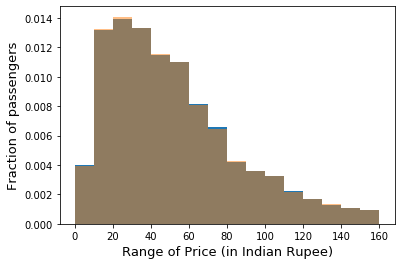

In [280]:
plt.hist(y_train, bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160], density = True, label = "Train", alpha = 1)
plt.hist(y_test, bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160], density = True, label = "Train", alpha = 0.5)
plt.xlabel('Range of Price (in Indian Rupee)',fontsize=13)
plt.ylabel('Fraction of passengers',fontsize=13)

(array([ 3680., 12455., 13230., 12486., 10866., 10329.,  7589.,  6086.,
         4006.,  3361.,  3035.,  2029.,  1610.,  1271.,  1040.,   865.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160]),
 <a list of 16 Patch objects>)

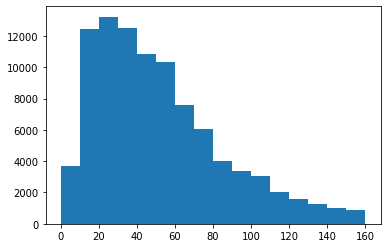

In [272]:
plt.hist(y_test, bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160])

In [ ]:
residual = y_test-y_pred_test

In [ ]:
plt.hist(residual, bins=[-50,-40,-30,-20,-10, 0, 10, 20, 30, 40,50])

In [ ]:
##---HyperParameter Training---DO NOT REFRESH THIS PART ------

In [ ]:
##---HyperParameter Training---

In [447]:
training_error = np.zeros(100)
testing_error = np.zeros(100)
import numpy as np
from sklearn.tree import DecisionTreeRegressor
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for i in range(1,100):
    reg = DecisionTreeRegressor(random_state = 0, max_depth = i)
    reg.fit(X_train, y_train)
    t1_response = datetime.now()
    y_pred_test = reg.predict(X_test)
    t2_response = datetime.now()
    y_pred_train = reg.predict(X_train)
    training_error[i] = metrics.mean_absolute_error(y_train, y_pred_train)/np.mean(y)
    testing_error[i] = metrics.mean_absolute_error(y_test, y_pred_test)/np.mean(y)

Text(0.5, 0, 'Depth of Tree')

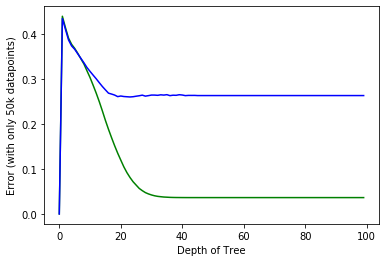

In [454]:
plt.plot(training_error, "-g" , label = "Training error")
plt.plot(testing_error, "-b", label="Testing error")
plt.ylabel('Error (with only 50k datapoints)')
plt.xlabel('Depth of Tree')

In [455]:
##---HyperParameter testing for Ridge regression---

Text(0.5, 0, 'Alpha of Ridge Regression (0.01 time X-label)')

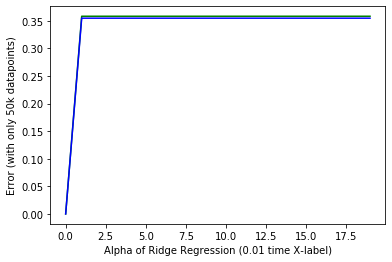

In [461]:
num_iter = 20
training_error = np.zeros(num_iter)
testing_error = np.zeros(num_iter)

import numpy as np
from sklearn import linear_model
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
for i in range(1,num_iter):
    reg = linear_model.Ridge(alpha=0.01*i)
    reg.fit(X_train, y_train)
    t1_response = datetime.now()
    y_pred_test = reg.predict(X_test)
    t2_response = datetime.now()
    y_pred_train = reg.predict(X_train)
    training_error[i] = metrics.mean_absolute_error(y_train, y_pred_train)/np.mean(y)
    testing_error[i] = metrics.mean_absolute_error(y_test, y_pred_test)/np.mean(y)

fig = plt.figure()
plt.plot(training_error, "-g" , label = "Training error")
plt.plot(testing_error, "-b", label="Testing error")
plt.ylabel('Error (with only 50k datapoints)')
plt.xlabel('Alpha of Ridge Regression (0.01 time X-label)')


In [ ]:
##---HyperParameter testing for LASSO--

Text(0.5, 0, 'Alpha of LASSO Regression (0.01 time X-label)')

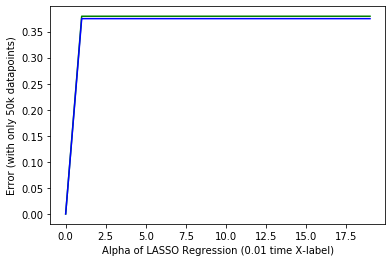

In [462]:
num_iter = 20
training_error = np.zeros(num_iter)
testing_error = np.zeros(num_iter)

import numpy as np
from sklearn import linear_model
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
for i in range(1, num_iter):
    reg = linear_model.Lasso(alpha=0.1)
    reg.fit(X_train, y_train)
    t1_response = datetime.now()
    y_pred_test = reg.predict(X_test)
    t2_response = datetime.now()
    y_pred_train = reg.predict(X_train)
    training_error[i] = metrics.mean_absolute_error(y_train, y_pred_train)/np.mean(y)
    testing_error[i] = metrics.mean_absolute_error(y_test, y_pred_test)/np.mean(y)

fig = plt.figure()
plt.plot(training_error, "-g" , label = "Training error")
plt.plot(testing_error, "-b", label="Testing error")
plt.ylabel('Error (with only 50k datapoints)')
plt.xlabel('Alpha of LASSO Regression (0.01 time X-label)')


In [ ]:
##---HyperParameter testing for Random forest regressor--

/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-v

Text(0.5, 0, 'number of estimators for RandomForestRegressor(100 time X-label)')

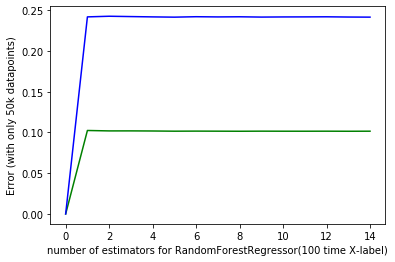

In [464]:
num_iter = 15
training_error = np.zeros(num_iter)
testing_error = np.zeros(num_iter)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
X = X_final
y = per_person_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
for i in range(1,num_iter):
    reg = RandomForestRegressor(n_estimators = i*100, random_state = i)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    t1_response = datetime.now()
    y_pred_test = reg.predict(X_test)
    t2_response = datetime.now()
    training_error[i] = metrics.mean_absolute_error(y_train, y_pred_train)/np.mean(y)
    testing_error[i] = metrics.mean_absolute_error(y_test, y_pred_test)/np.mean(y)

fig = plt.figure()
plt.plot(training_error, "-g" , label = "Training error")
plt.plot(testing_error, "-b", label="Testing error")
plt.ylabel('Error (with only 50k datapoints)')
plt.xlabel('number of estimators for RandomForestRegressor(100 time X-label)')

In [480]:
## Grid search on Random Forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 40, num = 8)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [500, 750, 1000, 1250, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [481]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train);
print(rf_random.best_params_)
best_random = rf_random.best_estimator_
Y_pred = best_random.predict(X_test)

print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, Y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 154.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 370.4min finished
/Users/ankitajain/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 35, 'bootstrap': True}
Absolute Mean Squared Error for test data: 1.4848173772307298


In [475]:
print('Absolute Mean Squared Error for test data:', metrics.mean_absolute_error(y_test, Y_pred))

Absolute Mean Squared Error for test data: 1.4871448150821998


array([31.03575011, 14.21493936, 12.76303624,  5.63103019])